In [2]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../.env", override=True)

True

In [2]:
from app import langsmith_rag

question = "How to learn Sieve of Eratosthenes?"
langsmith_rag(question)

USER_AGENT environment variable not set, consider setting it to identify your requests.
c:\Users\jaind\OneDrive\Documents\Study Material\College\Sem 3\Introduction to LLM\Projects\intro-to-langsmith\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


"To learn the Sieve of Eratosthenes, start by understanding its purpose: efficiently finding all prime numbers up to a given limit. Study the algorithm's steps—initializing a list of numbers, iteratively marking multiples of each prime as non-prime, and collecting the remaining primes. You can find tutorials, visualizations, and coding examples online in languages like Python to practice and deepen your understanding."

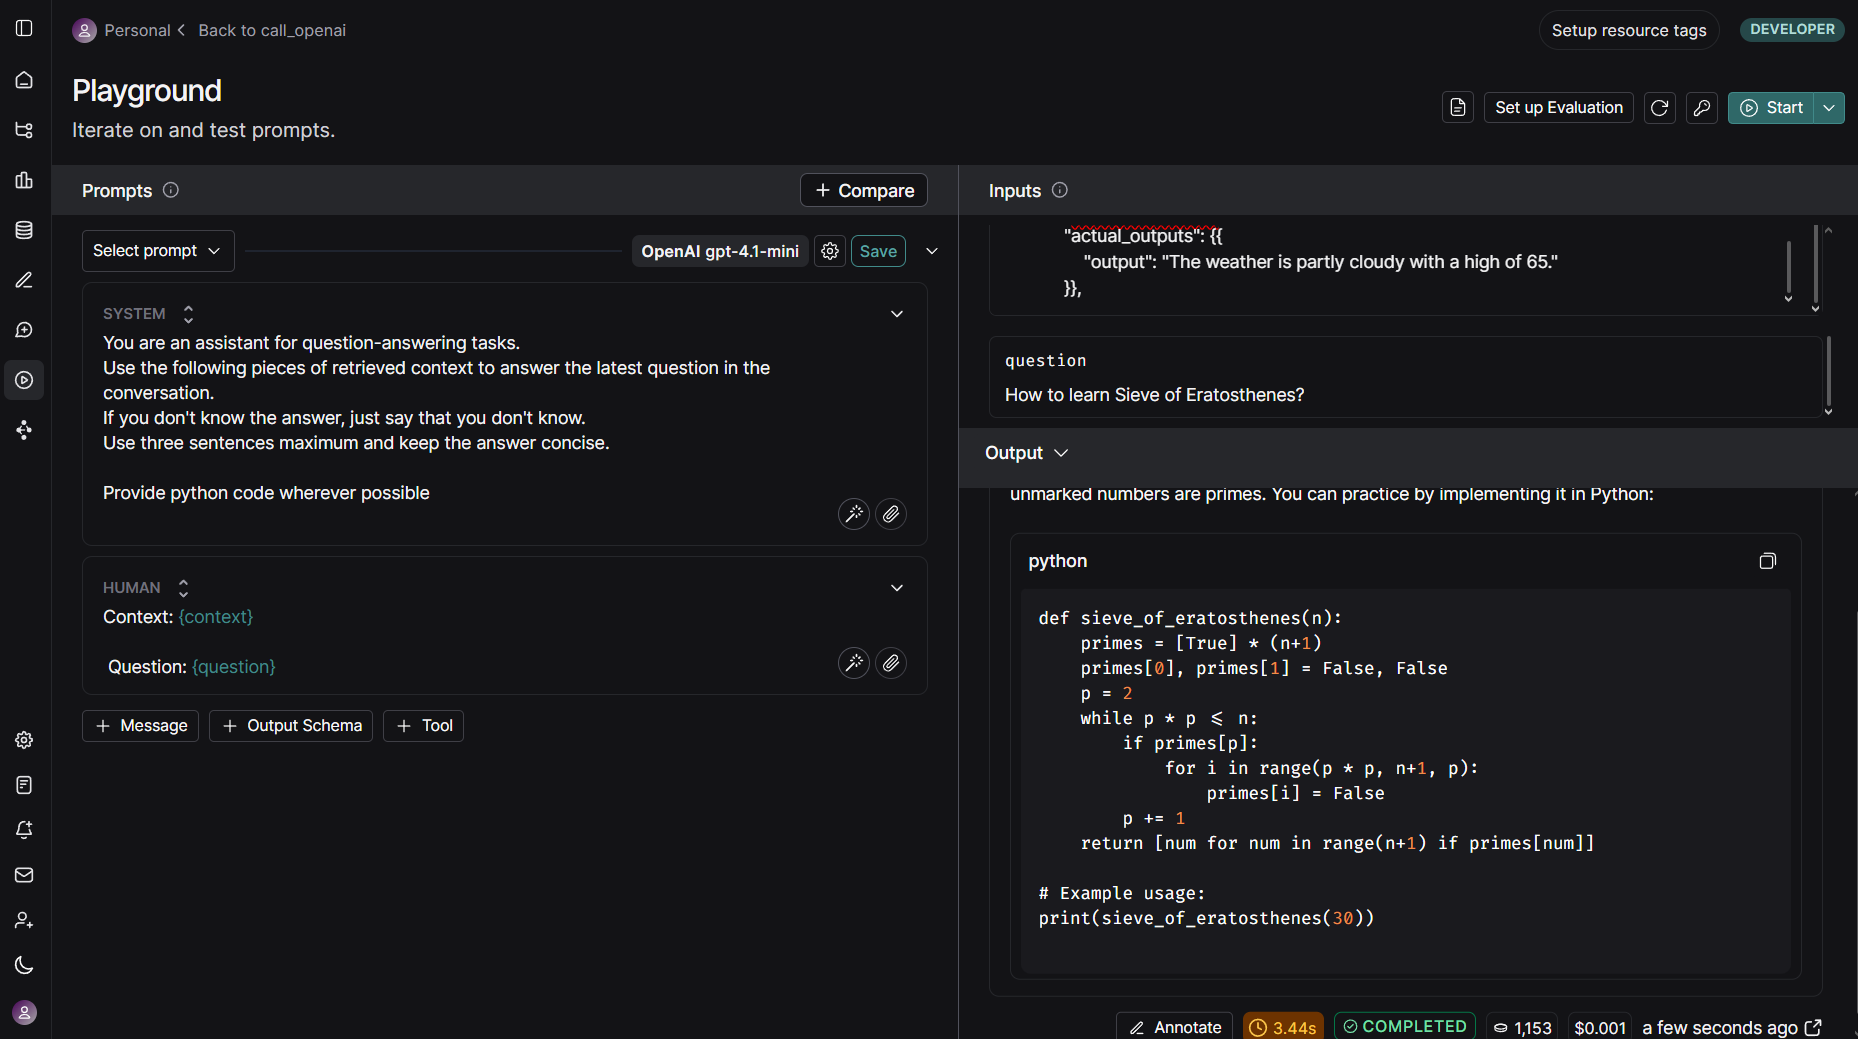

In [3]:
from langsmith import Client

bartending_dataset = [
    (
        "What is the difference between neat, on the rocks, and straight up?",
        "Neat: spirit served at room temperature with no ice or dilution. On the rocks: over ice. Straight up: chilled with ice (shaken or stirred), then strained with no ice in the glass.",
        "Neat is room-temp spirit without ice; on the rocks is served over ice; straight up is chilled with ice then strained with no ice."
    ),
    (
        "What are essential bar tools for basic cocktails?",
        "Core tools: jigger (accurate measuring), shaker (Boston or cobbler), bar spoon, Hawthorne and fine mesh strainers, muddler, citrus press, peeler, and a mixing glass for stirred drinks.",
        "Use a jigger, shaker, bar spoon, strainers (Hawthorne + fine), muddler, citrus press, peeler, and mixing glass for stirred cocktails."
    ),
    (
        "What are classic cocktail garnishes and how to choose them?",
        "Common garnishes: citrus twists or wheels (lemon/orange/lime), olives, cherries, and mint. Match garnish aroma and flavor to the build (e.g., lemon twist for spirit-forward citrus oils, mint for Mojito).",
        "Use citrus twists/wheels, olives, cherries, or mint; choose garnishes that complement the drink’s aroma and flavor."
    ),
    (
        "What are the specs for a Margarita?",
        "Classic spec: 2 oz tequila, 1 oz orange liqueur, 1 oz fresh lime juice; shake and strain; optional salt rim. Adjust 2:1:1 to taste and sweetness of orange liqueur.",
        "Use 2 oz tequila, 1 oz orange liqueur, 1 oz lime; shake and strain with optional salt rim."
    ),
    (
        "When should a drink be double strained?",
        "Double strain (Hawthorne plus fine mesh) after shaking with citrus, muddling, or when small ice shards/pulp would affect texture or clarity.",
        "Double strain shaken citrus or muddled cocktails to remove ice chips and pulp for a smoother texture."
    ),
    (
        "What is the basic Negroni spec?",
        "Equal parts build: 1 oz gin, 1 oz sweet vermouth, 1 oz Campari; stir with ice and strain over fresh ice or serve up; orange peel.",
        "Stir equal parts gin, sweet vermouth, and Campari; garnish with an orange peel."
    ),
    (
        "How do I make the 'Honey I’m Home' cocktail?",
        "A popular version builds a vodka-and-Licor 43 base with fresh lime, topped with ginger beer for brightness and light spice; garnish with a citrus wedge or honey-ginger accent.",
        "Shake 1.5 oz vodka, 0.5 oz Licor 43, and ~0.75 oz fresh lime; strain over ice and top with ginger beer; garnish with lime or honey-ginger."
    ),
    (
        "What are the specs for a 'Sex on the Beach'?",
        "Classic, fruit-forward highball built over ice with vodka, peach schnapps, cranberry, and orange; stirred and garnished simply.",
        "Build over ice: 1.5 oz vodka, 0.5 oz peach schnapps, 2 oz cranberry, 2 oz orange; brief stir; garnish with orange slice or cherry."
    ),
    (
        "How should I serve Macallan 18?",
        "Premium single malt typically served neat in a nosing glass; optional few drops of water to open aroma or a single large rock for slow dilution.",
        "Serve neat in a Glencairn; optionally add a few drops of water or one large cube for controlled dilution."
    ),
]


client = Client()
dataset_name = "Cocktail Basics"

dataset = client.create_dataset(
    dataset_name=dataset_name, description="Basic information regarding bartending and mixing cocktails"
)

inputs = [{"question": q, "context": c} for q, c, _ in bartending_dataset]
outputs = [{"output": o} for _, _, o in bartending_dataset]

client.create_examples(
    inputs=inputs,
    outputs=outputs,
    dataset_id=dataset.id,
)

{'example_ids': ['e44fe4ed-c220-45fc-b8d1-97ab0e11ba10',
  '93d96d0c-f820-4163-b8d8-a349f4d09873',
  '56bad26e-c340-4d01-a7ce-f13051c9329a',
  '6bca3734-1616-4dc6-9d50-bd3d0bbfe2b1',
  '967e999e-d192-4077-b4a6-72b2f4d5b1a3',
  '9e5a0ed8-69da-4d6e-84af-45d02f35f1b3',
  '4075ccf3-dcf7-434a-8788-dc1519569fc9',
  '3a563c81-07c2-4337-aff3-3beddfacc525',
  '46d9aa24-61e8-4186-a2e3-499cbad7ae73'],
 'count': 9}

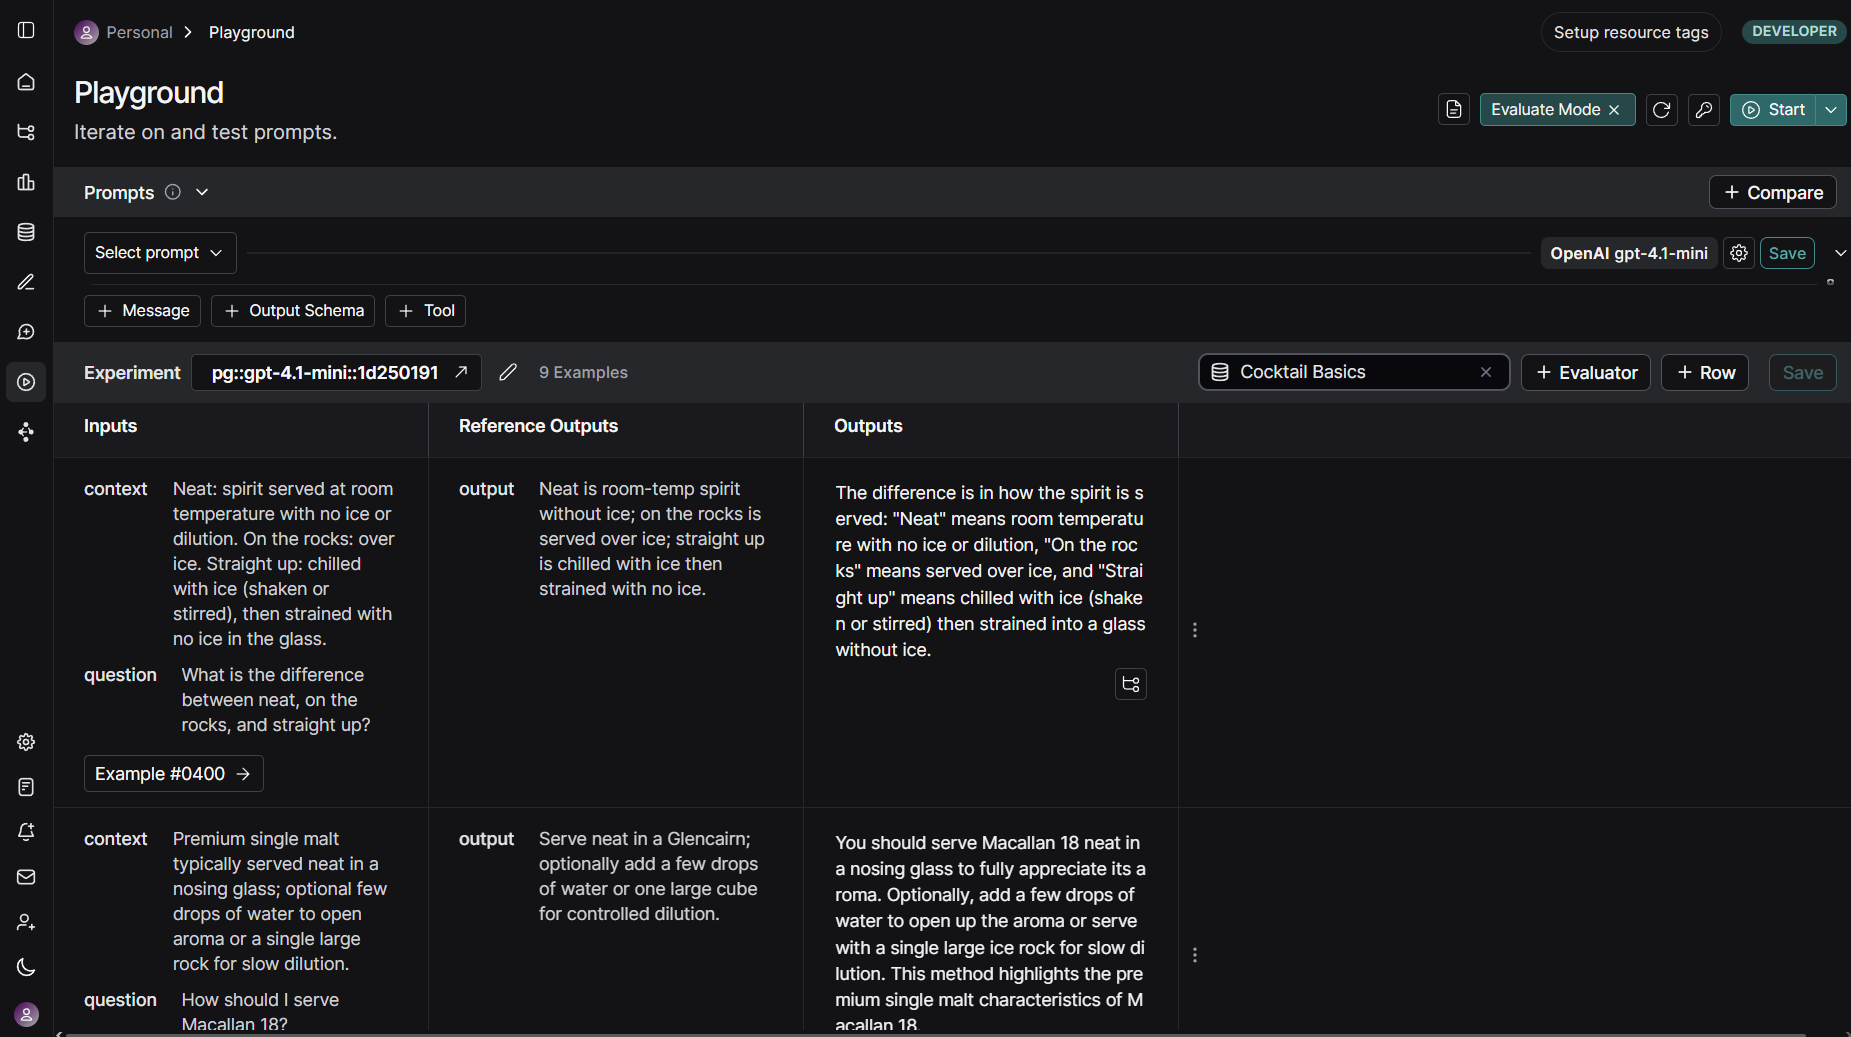

In [3]:
from langsmith import Client
client = Client()
prompt = client.pull_prompt("cocktail-mixing", include_model=True)

c:\Users\jaind\OneDrive\Documents\Study Material\College\Sem 3\Introduction to LLM\Projects\intro-to-langsmith\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import os
import tempfile
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders.sitemap import SitemapLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import OpenAIEmbeddings
from langsmith import traceable
from langsmith.client import convert_prompt_to_openai_format as convert
from openai import OpenAI
from typing import List
import nest_asyncio

MODEL_NAME = "gpt-4.1-mini"
MODEL_PROVIDER = "openai"
APP_VERSION = 1.0



openai_client = OpenAI()

def get_vector_db_retriever():
    persist_path = os.path.join(tempfile.gettempdir(), "union.parquet")
    embd = OpenAIEmbeddings()

    if os.path.exists(persist_path):
        vectorstore = SKLearnVectorStore(
            embedding=embd,
            persist_path=persist_path,
            serializer="parquet"
        )
        return vectorstore.as_retriever(lambda_mult=0)

    ls_docs_sitemap_loader = SitemapLoader(web_path="https://docs.smith.langchain.com/sitemap.xml", continue_on_failure=True)
    ls_docs = ls_docs_sitemap_loader.load()

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=500, chunk_overlap=0
    )
    doc_splits = text_splitter.split_documents(ls_docs)

    vectorstore = SKLearnVectorStore.from_documents(
        documents=doc_splits,
        embedding=embd,
        persist_path=persist_path,
        serializer="parquet"
    )
    vectorstore.persist()
    return vectorstore.as_retriever(lambda_mult=0)

nest_asyncio.apply()
retriever = get_vector_db_retriever()

"""
retrieve_documents
- Returns documents fetched from a vectorstore based on the user's question
"""
@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

"""
generate_response
- Calls `call_openai` to generate a model response after formatting inputs
"""
@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    response = prompt.invoke({
        "question": question,
        "context": formatted_docs
    })
    
    return response

"""
call_openai
- Returns the chat completion output from OpenAI
"""
@traceable(
    run_type="llm",
    metadata={
        "ls_provider": MODEL_PROVIDER,
        "ls_model_name": MODEL_NAME
    }
)
def call_openai(messages: List[dict]) -> str:
    return openai_client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
    )

"""
langsmith_rag
- Calls `retrieve_documents` to fetch documents
- Calls `generate_response` to generate a response based on the fetched documents
- Returns the model response
"""
@traceable(run_type="chain")
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    
    if hasattr(response, "content"):
        return response.content
    if isinstance(response, dict):
        if "choices" in response and response["choices"]:
            choice = response["choices"][0]
            msg = choice.get("message") or {}
            
            if isinstance(msg, dict) and "content" in msg:
                return msg["content"]
            if "content" in response:
                return response["content"]
        if "content" in response:
            return response["content"]
    
    return str(response)


In [7]:
questions = [
    "What is the difference between neat, on the rocks, and straight up?",
    "What are essential bar tools for basic cocktails?",
    "What are classic cocktail garnishes and how to choose them?",
    "What are the specs for a Margarita?",
    "When should a drink be double strained?",
    "What is the basic Negroni spec?",
    "How do I make the 'Honey I’m Home' cocktail?",
    "How should I serve Macallan 18?",
    "What are the specs for a 'Sex on the Beach'?",
]

for i in questions:
    print(f"Question: {i}")
    print(f"Response: {langsmith_rag(i)}\n")

Question: What is the difference between neat, on the rocks, and straight up?
Response: The difference between "neat," "on the rocks," and "straight up" refers to how a drink is served. "Neat" means the liquor is served plain without ice or mixers, "on the rocks" means served over ice, and "straight up" means the drink is chilled, usually by shaking or stirring with ice, but served without ice. These terms are commonly used for spirits like whiskey or cocktails.

Question: What are essential bar tools for basic cocktails?
Response: Essential bar tools for basic cocktails typically include a shaker (Boston or Cobbler), a jigger (for measuring), a strainer, a muddler, a bar spoon, and a citrus juicer or reamer. These tools help in mixing, measuring, and preparing various cocktail ingredients efficiently.

Question: What are classic cocktail garnishes and how to choose them?
Response: Classic cocktail garnishes include citrus twists or wedges (lemon, lime, orange), cocktail cherries, oliv